In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from LSTM_model import LSTM


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)

In [2]:

file_path = '../../data/dataS.csv'
df = pd.read_csv(file_path, parse_dates=['Date'])
df.sort_values('Date', inplace=True, ignore_index=True)

features = ['volatility']
target   = 'volatility_forcast'
data_X   = df[features].values
data_y   = df[[target]].values

In [3]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(data_X)
y_scaled = scaler_y.fit_transform(data_y)


In [4]:
def create_sequences(X, y, seq_length):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i : i + seq_length])
        ys.append(y[i + seq_length])
    return np.array(Xs), np.array(ys)


seq_length = 20
X_seq, y_next = create_sequences(X_scaled, y_scaled, seq_length)


In [5]:

X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_next,
    test_size=0.2,
    shuffle=False
)

def build_y_seqs(y_flat, seq_length):
    N = len(y_flat)
    y_seqs = np.zeros((N, seq_length, 1), dtype=float)
    for i in range(N):
        y_seqs[i, :, 0] = y_flat[i]
    return y_seqs

Y_train = build_y_seqs(y_train, seq_length)
Y_test  = build_y_seqs(y_test, seq_length)


In [6]:
model = LSTM(
    input_dim = X_train.shape[2],   # number of features
    hidden_dim= 64,
    output_dim= 1,
    lr        = 1e-3
)

model.train(
    X_train, Y_train,
    epochs     = 100,
    batch_size = 32,
    val_data   = (X_test, Y_test)
)

Epoch 1/100 — train MSE: 0.0060 — val MSE: 0.0041
Epoch 2/100 — train MSE: 0.0053 — val MSE: 0.0042
Epoch 3/100 — train MSE: 0.0053 — val MSE: 0.0043
Epoch 4/100 — train MSE: 0.0052 — val MSE: 0.0043
Epoch 5/100 — train MSE: 0.0053 — val MSE: 0.0042
Epoch 6/100 — train MSE: 0.0052 — val MSE: 0.0042
Epoch 7/100 — train MSE: 0.0052 — val MSE: 0.0042
Epoch 8/100 — train MSE: 0.0052 — val MSE: 0.0040
Epoch 9/100 — train MSE: 0.0052 — val MSE: 0.0041
Epoch 10/100 — train MSE: 0.0052 — val MSE: 0.0041
Epoch 11/100 — train MSE: 0.0052 — val MSE: 0.0041
Epoch 12/100 — train MSE: 0.0052 — val MSE: 0.0043
Epoch 13/100 — train MSE: 0.0052 — val MSE: 0.0040
Epoch 14/100 — train MSE: 0.0052 — val MSE: 0.0040
Epoch 15/100 — train MSE: 0.0052 — val MSE: 0.0041
Epoch 16/100 — train MSE: 0.0052 — val MSE: 0.0041
Epoch 17/100 — train MSE: 0.0052 — val MSE: 0.0041
Epoch 18/100 — train MSE: 0.0052 — val MSE: 0.0042
Epoch 19/100 — train MSE: 0.0051 — val MSE: 0.0041
Epoch 20/100 — train MSE: 0.0052 — val M

In [7]:
preds_seq = model.predict(X_test)         # shape (N_test, seq_length, 1)
preds_last = preds_seq[:, -1, 0]
y_last     = y_test[:, 0]

preds_inv = scaler_y.inverse_transform(preds_last.reshape(-1,1)).flatten()
y_inv     = scaler_y.inverse_transform(y_last.reshape(-1,1)).flatten()

mse   = mean_squared_error(y_inv, preds_inv)
rmse  = np.sqrt(mse)
mae   = mean_absolute_error(y_inv, preds_inv)
mape  = mean_absolute_percentage_error(y_inv, preds_inv)
r2    = r2_score(y_inv, preds_inv)


print("\nFinal Test Metrics:")
print(f"  MSE : {mse:.6f}")
print(f"  RMSE: {rmse:.6f}")
print(f"  MAE : {mae:.6f}")
print(f"  MAPE: {mape:.2%}")
print(f"  R²  : {r2:.4f}")


Final Test Metrics:
  MSE : 0.002921
  RMSE: 0.054047
  MAE : 0.038735
  MAPE: 60.86%
  R²  : 0.4224


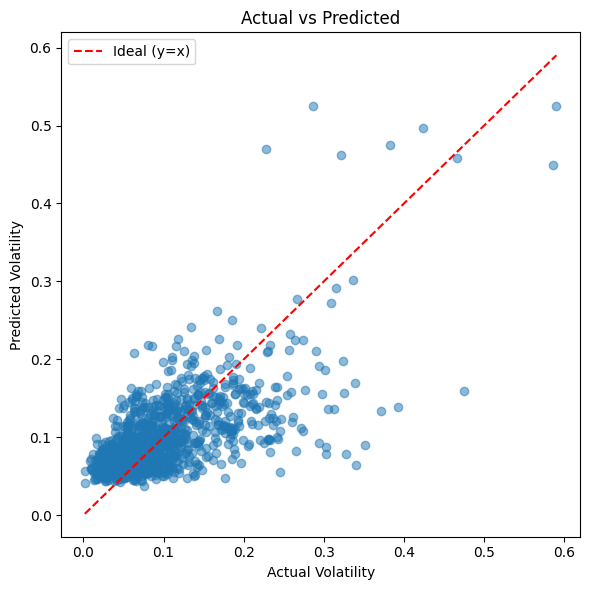

In [8]:
preds_seq = model.predict(X_test)        # (N_test, seq_len, 1)
preds_last = preds_seq[:, -1, 0]
y_last     = y_test[:, 0]

preds_inv = scaler_y.inverse_transform(preds_last.reshape(-1,1)).flatten()
y_inv     = scaler_y.inverse_transform(y_last.reshape(-1,1)).flatten()

plt.figure(figsize=(6,6))
plt.scatter(y_inv, preds_inv, alpha=0.5)
lims = [
    min(y_inv.min(), preds_inv.min()),
    max(y_inv.max(), preds_inv.max())
]
plt.plot(lims, lims, 'r--', label='Ideal (y=x)')
plt.xlabel('Actual Volatility')
plt.ylabel('Predicted Volatility')
plt.title('Actual vs Predicted')
plt.legend()
plt.tight_layout()
plt.show()

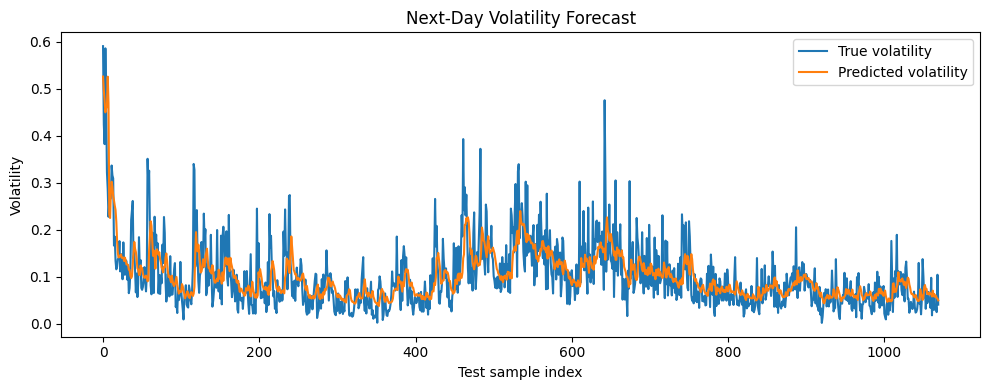

In [9]:
plt.figure(figsize=(10,4))
plt.plot(y_inv,    label='True volatility')
plt.plot(preds_inv, label='Predicted volatility')
plt.title('Next-Day Volatility Forecast')
plt.xlabel('Test sample index')
plt.ylabel('Volatility')
plt.legend()
plt.tight_layout()
plt.show()